## Classification of species using iris dataset from sklearn

* load modules

In [93]:
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier #baseline model
from sklearn.ensemble import RandomForestClassifier # comparisson model
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # easier to create visualizations 

* load dataset

In [94]:
# Load the iris dataset
data = load_iris(as_frame=True)
iris = pd.concat([data.data, data.target], axis=1)

# Create a dict of new column names and values
map_names = {
    0 : data.target_names[0],
    1 : data.target_names[1],
    2 : data.target_names[2]
}

# Add the new columns to the dataframe
iris['target_name'] = [ map_names[x] for x in iris['target']]

# Print the dataframe
display(iris.head(), iris.shape, iris.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


(150, 6)

None

* Using the base dataset without feature engeniering
    - find an optimal number of clusters
    - check variance of the veatures
    - implement standartization if necessary
    - use both models
    - vizualize the results

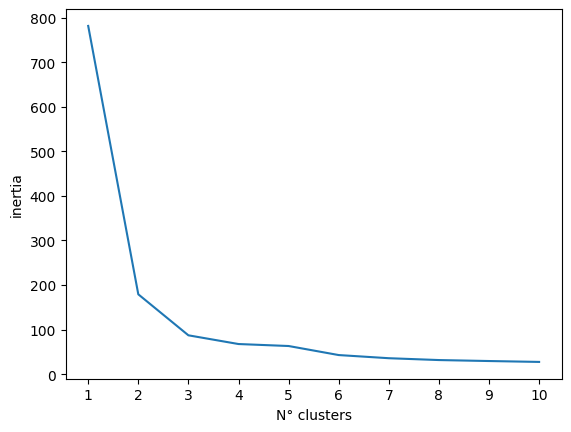

In [95]:
# calculate the optimal number of clusters

list_n_clusters = np.arange(1,11,1)

inertias = []

for n_cluster in list_n_clusters:
    model = KMeans(n_clusters=n_cluster, n_init='auto')
    model.fit(iris.iloc[:,:-1])
    inertias.append(model.inertia_)

plt.plot(list_n_clusters, inertias)
plt.xlabel('N° clusters')
plt.ylabel('inertia')
plt.xticks(list_n_clusters)
plt.show()

* check variance of features

In [96]:
iris.iloc[:,:-2].var()

sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
dtype: float64

* check variance of the features using pairplot

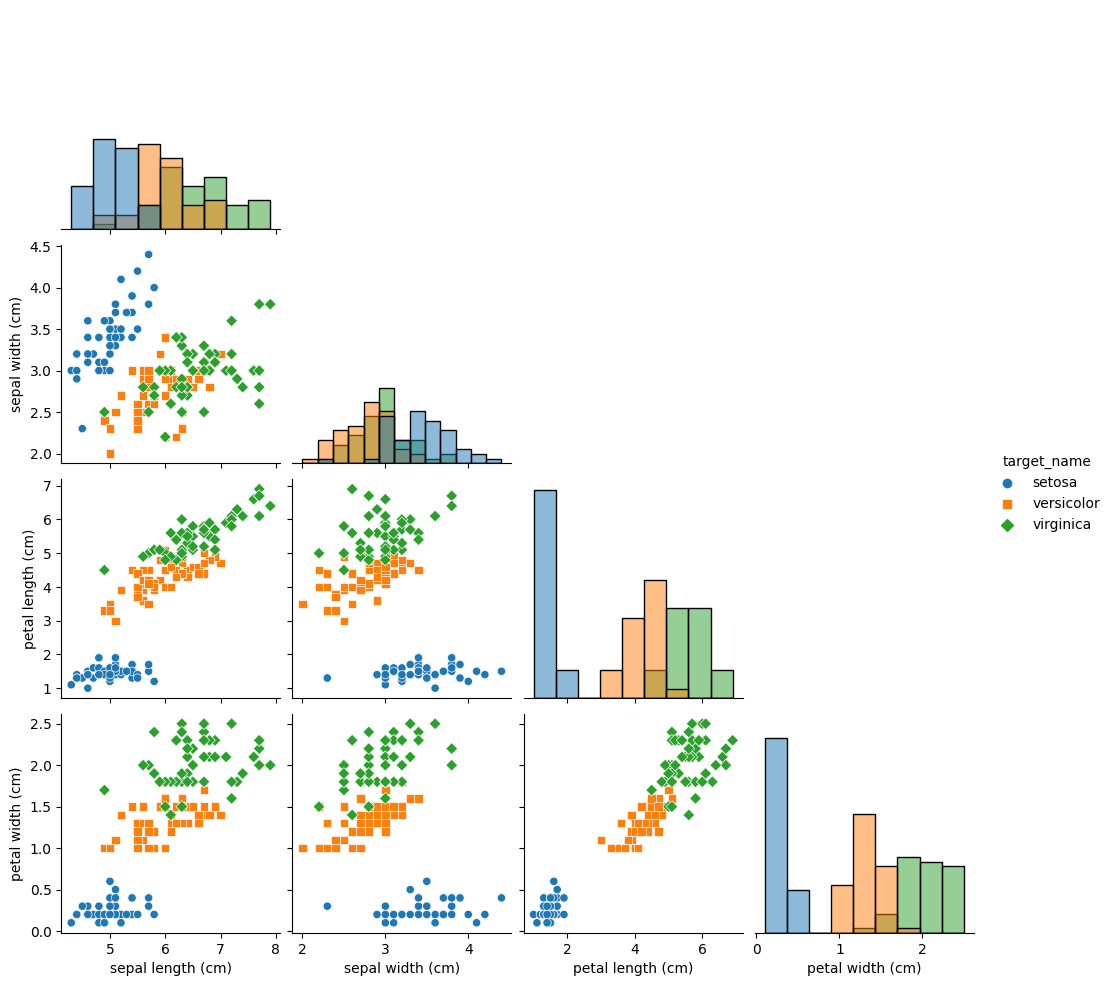

In [97]:
sns.pairplot(data=iris, vars=iris.iloc[:,:-2], diag_kind='hist', hue='target_name', markers=['o','s','D'], corner=True)

* Conclusion
    - the features seems to be well divided within the targets
    - no standardization needed

* Implementing the models

In [98]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, algorithm='auto')
rfc_model = RandomForestClassifier(n_jobs=-1)

* split the data into train and test

In [99]:
X_train, X_test, y_train, y_test = tts(iris.iloc[:,:3], iris['target_name'].values, train_size=0.33, random_state=42)

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49, 3)

(101, 3)

(49,)

(101,)

* Train the models and generate predictions

In [100]:
knn_model.fit(X_train,y_train)
rfc_model.fit(X_train, y_train)

knn_preds = knn_model.predict(X_test)
rfc_preds = rfc_model.predict(X_test)

knn_proba = knn_model.predict_proba(X_test)
rfc_proba = rfc_model.predict_proba(X_test)

* generate onehot labels for roc curve plotting

In [101]:
from sklearn.preprocessing import LabelBinarizer

label_bin = LabelBinarizer().fit(y_train)
y_test_ohe = label_bin.transform(y_test)

display(y_test_ohe.shape)

(101, 3)

In [102]:
from itertools import cycle
def plot_roc_curve(y_test_ohe, proba, label_bin):
    colors = {0:'aqua' , 1:'darkorange' , 2:'cornflowerblue'}
    fig, ax = plt.subplots()
    for class_of_interest in label_bin.classes_:
        class_id = np.flatnonzero(label_bin.classes_ == class_of_interest)[0]
        metrics.RocCurveDisplay.from_predictions(
            y_test_ohe[:, class_id],
            proba[:, class_id],
            name = f'ROC curve for {data.target_names[class_id]}',
            color=colors[class_id],
            ax=ax,
            linestyle=':'
        )

* Plot for KNeighborsClassifier

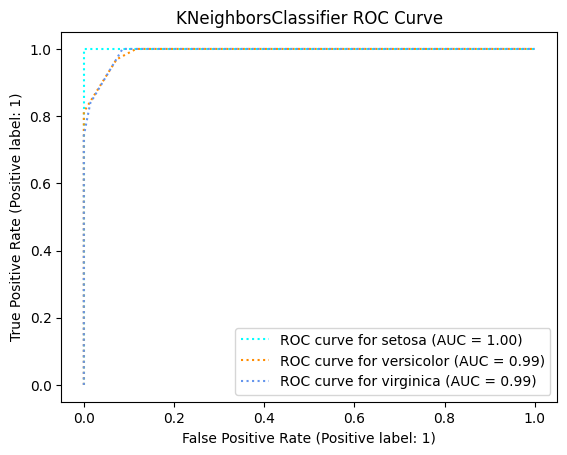

In [103]:
plot_roc_curve(y_test_ohe, knn_proba, label_bin)
plt.title('KNeighborsClassifier ROC Curve')
plt.show()

* Plot for RandomForestClassifier

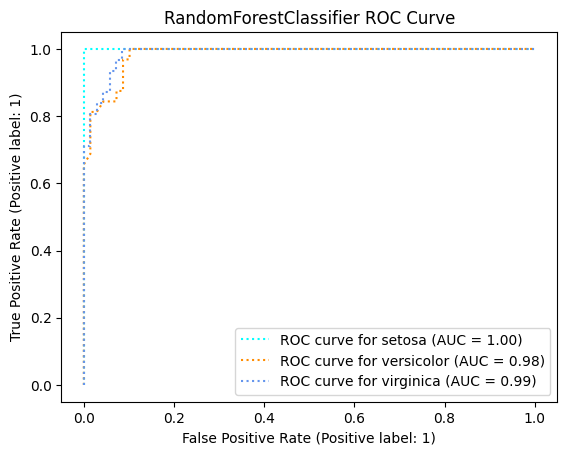

In [104]:
plot_roc_curve(y_test_ohe, rfc_proba, label_bin)
plt.title('RandomForestClassifier ROC Curve')
plt.show()

* Scoring the models

In [105]:
# accuracy

acc_knn = metrics.accuracy_score(y_test, knn_preds)
acc_rfc = metrics.accuracy_score(y_test, rfc_preds)

print(f'KNN accuracy: {acc_knn:.2f}\n')
print(f'RFC accuracy: {acc_rfc:.2f}')

# ROC AUC score

roc_auc_knn = metrics.roc_auc_score(y_test, knn_proba, multi_class='ovr')
roc_auc_rfc = metrics.roc_auc_score(y_test, rfc_proba, multi_class='ovr')

print(f'roc_auc ovr score for KNN: {roc_auc_knn:.2f}\n')
print(f'roc_auc ovr score for RFC: {roc_auc_rfc:.2f}\n')



KNN accuracy: 0.94

RFC accuracy: 0.92
roc_auc ovr score for KNN: 0.99

roc_auc ovr score for RFC: 0.99



## Conclusion

I built two classification models to predict the species of iris flower given four features: sepal length, sepal width, petal length, and petal width. The models were a KNeighborsClassifier (KNN) and a RandomForestClassifier (RFC).

The results of the models on the Iris dataset from sklearn are as follows:

* KNN accuracy: 0.94
* RFC accuracy: 0.93
* ROC_AUC OVR score for KNN: 0.99
* ROC_AUC OVR score for RFC: 0.99

Both models performed well on the Iris dataset, with KNN achieving a slightly higher accuracy of 0.94. However, both models had a ROC_AUC OVR score of 0.99, which indicates that they were both very good at predicting the iris species with high confidence.

**Overall, the results of this project show that both KNN and RFC are effective machine learning algorithms for classifying iris flowers. However, KNN may be a slightly better choice for this particular dataset due to its slightly higher accuracy.**

